## Model Factory

In [1]:
#libraries for modeling
from multiprocessing.pool import ThreadPool
from pyspark import SparkContext
from pyspark.sql import SQLContext, SparkSession, Window, Row
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator
import pyspark.sql.functions as F
import itertools
from itertools import repeat
import pickle
import pyspark
import copy

from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

#libraries for plotting
import matplotlib.gridspec as gridspec
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

class CreateBestModel:
    def __init__(self, algo, avgprecision, avgrecall, avgfscore, hyperparams, ootmodel, ootprecision, ootrecall, ootfscore):
        self.algo = algo
        self.gsPrecision = avgprecision
        self.gsFScore = avgfscore
        self.gsRecall = avgrecall
        self.hyperParams = hyperparams
        self.model = ootmodel
        self.ootPrecision = ootprecision
        self.ootFScore = ootfscore
        self.ootRecall = ootrecall

#function-based
def sample(df, sampling_method, ratio):

    notfraud = df.select('*').where(df.Class == 0.0)
    fraud = df.select('*').where(df.Class == 1.0)

    if sampling_method == "over":
        nrows = notfraud.select("Class").count()
        sample_size = int(nrows*ratio/(1-ratio))
        sampled = fraud.rdd.takeSample(True, sample_size, 46)
        fraud = sqlContext.createDataFrame(sampled)

    elif sampling_method == "under":
        nrows = fraud.select("Class").count()
        sample_size = int(nrows*(1-ratio)/ratio)
        sampled = notfraud.rdd.takeSample(False, sample_size, 46)
        notfraud = sqlContext.createDataFrame(sampled)

    sampled = fraud.union(notfraud)
    fraud_count = sampled.select("Class").where(sampled.Class == 1.0).count()
    tot_count = sampled.select("Class").count()
    fraud_ratio = fraud_count / tot_count

    print("train after sampling: " + str(tot_count))
    print("fraud ratio: " + str(fraud_ratio))

    #shuffle undersampled dataframe
    nrows = sampled.select("Class").count()
    shuffled = sampled.rdd.takeSample(False, nrows, 46)
    shuffled_df = sqlContext.createDataFrame(shuffled)

    return shuffled_df

def generateParamGrid(*args):
    
    grid = list(itertools.product(*args))
    return grid

def generateClassifier(algo, params, features):

    ############################################################################
    #TODO: complete this section

    def lr(params,features):
        print(params)
        if len(params) > 2:
            lrClassifier = LogisticRegression(featuresCol = 'features',
                                          labelCol = 'Class',
                                          threshold=params[0],
                                           maxIter=params[1],
                                           weightCol=params[2])
                                          #regParam=params[2])
                                          #elasticNetParam=params[2])
        else:
            lrClassifier = LogisticRegression(featuresCol = 'features',
                                          labelCol = 'Class',
                                          threshold=params[0],
                                           maxIter=params[1])
        return lrClassifier


    def gbm(params,features):
        gbmClassifier = GBTClassifier(featuresCol = 'features',
                                      labelCol = 'Class',
                                      maxDepth = params[0],
                                      maxIter = params[1],
                                     stepSize = params[2])
        return gbmClassifier

    def rf(params,features):
        rfClassifier = RandomForestClassifier(featuresCol='features',
                                              labelCol='Class',
                                              maxDepth=params[0],
                                              minInfoGain=params[1],
                                              numTrees=params[2])

        return rfClassifier

    def mlp(params,features):
        input_layers = len(features)
        layers = [input_layers, params[1], 2]
        print(layers)
        mlpClassifier = MultilayerPerceptronClassifier(featuresCol = 'features',
                                                       labelCol = 'Class',
                                                       maxIter = params[0],
                                                       layers = layers,
                                                       stepSize = params[2])
        return mlpClassifier

    def svm(params, features):
        svmClassifier = LinearSVC(featuresCol = 'features',
                         labelCol='Class', 
                         standardization=True,
                         maxIter=params[0],
                         regParam=params[1],
                         tol =params[2]
                         )
        
        return svmClassifier

    def xg(params,features):
        return
    ############################################################################

    getClassifier = {
        'lr':lr,
        'gbm':gbm,
        'rf':rf,
        'mlp':mlp,
        'svm':svm,
        'xg':xg}

    return getClassifier[algo](params,features)

def crossValidate(df, folds, k, classifier, features, sampling_method, ratio, pool):

    def build(fold, df, classifier, features, sampling_method, ratio):

        #undersample notfraud
        validation = fold
        train = df.subtract(fold)

#         #add class weight
#         notfraud_count = train.select("Class").where(train.Class == 0.0).count()
#         total_count = train.select("Class").count()
#         balance_ratio = notfraud_count / total_count
#         train=train.withColumn("classWeights", F.when(train.Class == 1.0,balance_ratio).otherwise(1-balance_ratio))
        
        train = sample(train, sampling_method, ratio)
        vectorAssembler = VectorAssembler(inputCols = features, outputCol = 'features')
        vector_train = vectorAssembler.transform(train)
        vector_validate = vectorAssembler.transform(validation)
        model = classifier.fit(vector_train)
        pred = model.transform(vector_validate)
        pos = pred.filter(pred.prediction == 1.0).count()
        if pos != 0:
            precision = pred.filter(pred.Class == pred.prediction).filter(pred.Class == 1.0).count() / pos
        else:
            precision = 0
        fraud = pred.filter(pred.Class == 1.0).count()
        if fraud != 0:
            recall = pred.filter(pred.Class == pred.prediction).filter(pred.Class == 1.0).count() / fraud
        else:
            recall = 0
        precision_recall = precision + recall
        if precision_recall != 0:
            f_score = 2 * precision * recall /(precision_recall)
        else:
            f_score = 0
        #print("\n precision, recall, f_score: " + str(precision) + ", " + str(recall) + ", " + str(f_score))
        return [precision, recall, f_score]

    #call multiprocessing here
    cvperformance = pool.map(lambda fold: build(fold, df, classifier, features, sampling_method, ratio), folds)

    #calculate metrics
    precision_sum = sum([x[0] for x in cvperformance])
    recall_sum = sum([x[1] for x in cvperformance])

    avg_precision = precision_sum/k
    avg_recall = recall_sum/k
    if avg_precision+avg_recall == 0:
        avg_fscore = 0
    else:
        avg_fscore = 2 * avg_precision * avg_recall /(avg_precision+avg_recall)
    return [avg_precision,avg_recall,avg_fscore]

def gridSearch(df, folds, k, algo, grid, features, sampling_method, ratio, pool):

    best_hyper = None
    best_precision = 0
    best_recall = 0
    best_fscore = 0

    for i in range(len(grid)):
        params = list(grid[i])
        print(params)
        classifier = generateClassifier(algo, params, features)
        modelPerformance = crossValidate(df, folds, k, classifier, features, sampling_method, ratio, pool)
        print(modelPerformance)
        if modelPerformance[2] > best_fscore:
            best_hyper = params
            best_precision = modelPerformance[0]
            best_recall = modelPerformance[1]
            best_fscore = modelPerformance[2]

    return best_hyper, best_precision, best_recall, best_fscore

def ootTest(traindf,testdf, algo,features,params):
    vectorAssembler = VectorAssembler(inputCols = features, outputCol = 'features')
    classifier = generateClassifier(algo, params, features)
    vector_train = vectorAssembler.transform(traindf)
    vector_test = vectorAssembler.transform(testdf)
    ootmodel = classifier.fit(vector_train)
    pred = ootmodel.transform(vector_test)
    pos = pred.filter(pred.prediction == 1.0).count()
    if pos != 0:
        precision = pred.filter(pred.Class == pred.prediction).filter(pred.Class == 1.0).count() / pos
    else:
        precision = 0
    fraud = pred.filter(pred.Class == 1.0).count()
    if fraud != 0:
        recall = pred.filter(pred.Class == pred.prediction).filter(pred.Class == 1.0).count() / fraud
    else:
        recall = 0
    precision_recall = precision + recall
    if precision_recall != 0:
        f_score = 2 * precision * recall /(precision_recall)
    else:
        f_score = 0
    print("\n precision, recall, f_score: " + str(precision) + ", " + str(recall) + ", " + str(f_score))
    
    return ootmodel, precision, recall, f_score

def tune(df, k, stratification_flag, sampling_method, ratio, modelobj_flag, features, algo, *args, **kwargs):

    """
    Entry point of this suite of functions. returns cv metrics or a model object
    Example:
        >>> cv_hyper, cv_precision, cv_recall, cv_fscore = tune(df, 5, True,
        'None', 0, False, features, 'mlp', [100], [15], [0.03])
    :param df: data for modeling purpose
    :type df: : pyspark dataframe
    :param k: number of folds for cross validation
    :type k: int
    :param stratification_flag: specifies whether fraud ratio is fixed for each fold. True for stratification
    :type stratification_flag: boolean
    :param sampling_method: "over" for oversampling minority class, "under" for undersampling majority class, "None"
    :type sampling_method: str
    :param ratio: targeted fraud ratio after sampling.
    :type ratio: float
    :param modelobj_flag: specifies whether to return a model object for out of time test. if False, returns cv performancce
    :type modelobj_flag: float
    :param features: features for training
    :type features: list
    :param *args: a sequence of params for hyperparams tuning. ex. [values for params1], [values for params2],...
    :type *args: list
    :returns: model object or cross validation metrics depending on modelobj_flag
    """


    pool = ThreadPool(3)

    #reduce df dimenions to include features and class
    cols = features+['Class', 'index']
    df = df.select(cols)
    df = df.select(*(F.col(c).cast("double").alias(c) for c in df.columns))
    df.cache()
    #df.drop("index")
    
    ########################ClassWeights#################################
    if algo in ["lr", "svm"] and ["ClassWeigts"] in args:
        #add class weight
        balance_ratio = args[-1][0]
        df=df.withColumn("classWeights", when(df.Class == 1.0,balance_ratio).otherwise(1-balance_ratio))
    ########################ClassWeights#################################
    
    folds = []
    
    if stratification_flag == False:
        tot_count = df.select("Class").count()
        n = int(tot_count / k)

        #create sub-dataframe iteratively
        fold_start = 1
        fold_end = n
        for i in range(k):
            fold = df.select('*').where(df.index.between(fold_start, fold_end))
            folds.append(fold)
            fold_start = fold_end + 1
            fold_end = fold_start + n
            if i == k-2:
                end = tot_count
                
    if stratification_flag == True:
        fraud = df.select("*").where(df.Class == 1.0)
        #shuffle undersampled dataframe
        nrows = fraud.select("Class").count()
        shuffled = fraud.rdd.takeSample(False, nrows, 46)
        fraud = sqlContext.createDataFrame(shuffled)
        #add row index to dataframe
        fraud = fraud.withColumn('dummy', F.lit('7'))
        fraud = fraud.withColumn("temp_index", F.row_number().over(Window.partitionBy("dummy").orderBy("dummy")))
        fraud = fraud.drop('dummy')
        fraud_count = fraud.select("Class").count()
        each_fraud = int(fraud_count/k)

        notfraud = df.select("*").where(df.Class == 0.0)
        nrows = notfraud.select("Class").count()
        shuffled = notfraud.rdd.takeSample(False, nrows, 46)
        notfraud = sqlContext.createDataFrame(shuffled)
        #add row index to dataframe
        notfraud = notfraud.withColumn('dummy', F.lit('7'))
        notfraud = notfraud.withColumn("temp_index", F.row_number().over(Window.partitionBy("dummy").orderBy("dummy")))
        notfraud = notfraud.drop('dummy')
        notfraud_count = notfraud.select("Class").count()
        each_notfraud = int(notfraud_count/k)

        fraud_start = 1
        fraud_end = each_fraud
        notfraud_start = 1
        notfraud_end = each_notfraud

        for i in range(k):
            fraud_fold  = fraud.select('*').where(fraud.temp_index.between(fraud_start, fraud_end))
            notfraud_fold = notfraud.select('*').where(notfraud.temp_index.between(notfraud_start, notfraud_end))
            fold = fraud_fold.union(notfraud_fold).drop("temp_index")
            folds.append(fold)
            fraud_start = fraud_end + 1
            fraud_end = fraud_start + each_fraud
            notfraud_start = notfraud_end + 1
            notfraud_end = notfraud_start + each_notfraud
            if i == k-2:
                fraud_end = fraud_count
                notfraud_end = notfraud_count


    #generate hyperparam combo
    grid = generateParamGrid(*args)

    #conduct grid search:
    best_hyper, best_precision, best_recall, best_fscore = gridSearch(df, folds, k, algo, grid, features, sampling_method, ratio, pool)

    if modelobj_flag == True:
        #generate a model obj
        traindf = sample(df, sampling_method, ratio)
        testdf = sqlContext.read.csv("oot.csv", header = True)
        cols = features+['Class', 'index']
        testdf = testdf.select(cols)
        testdf = testdf.select(*(F.col(c).cast("double").alias(c) for c in testdf.columns))
        model, precision, recall, fscore = ootTest(traindf, testdf, algo,features,best_hyper)
        
        modelobj = CreateBestModel(algo, best_precision, best_recall, best_fscore, best_hyper, 
                                   model, precision, recall, fscore)
        return modelobj

    return best_hyper, best_precision, best_recall, best_fscore

def save(content, filename):

    pickle.dump(content, open(filename, "wb"))

def load(filename):

    content = pickle.load(open(filename, "rb"))
    return content

def generateStratifiedFolds(df,k):

    return folds

In [2]:
sc=pyspark.SparkContext.getOrCreate()
sqlContext = SQLContext(sc)

## Step 1: Default Baseline Model

In [3]:
#Import Spark session
sc=pyspark.SparkContext.getOrCreate()
sqlContext = SQLContext(sc)

#read file as dataframe
train_df= sqlContext.read.format('com.databricks.spark.csv').options(header='true', inferschema='true').load('base_train.csv')
test_df= sqlContext.read.format('com.databricks.spark.csv').options(header='true', inferschema='true').load('base_test.csv')

vectorAssembler = VectorAssembler(inputCols = ['V1','V2','V3','V4','V5','V6','V7','V8','V9','V10','V11','V12','V13','V14','V15','V16','V17','V18','V19','V20','V21','V22','V23','V24','V25','V26','V27','V28','Amount'], outputCol = 'features')
train_df_v = vectorAssembler.transform(train_df)
test_df_v = vectorAssembler.transform(test_df)
gbt = GBTClassifier(featuresCol = 'features',labelCol = 'Class')

gbt_model = gbt.fit(train_df_v)
gbt_prediction = gbt_model.transform(test_df_v)
gbt_prediction.select('features','Class','prediction').show()


In [10]:
evaluator = BinaryClassificationEvaluator(labelCol="Class", metricName="areaUnderROC")
area = evaluator.evaluate(gbt_prediction)
pred = gbt_prediction
precision = pred.filter(pred.Class == pred.prediction).filter(pred.Class == 1.0).count() / pred.filter(pred.prediction == 1.0).count()
recall = pred.filter(pred.Class == pred.prediction).filter(pred.Class == 1.0).count() / pred.filter(pred.Class == 1.0).count()
f1 = 2 * precision * recall /(precision + recall)
print("Precision is ", precision)
print("Recall is ", recall)
print("F1 score is ", f1)
print("Test Area Under ROC: " + str(area))

Precision is  0.922077922077922
Recall is  0.7802197802197802
F1 score is  0.8452380952380951
Test Area Under ROC: 0.9847701355040529


## Step 2: Compare random cv and stratified cv

### Random CV

In [17]:
df = sqlContext.read.csv("base_train.csv", header = True)
features = ['V1','V2','V3','V4','V5','V6','V7','V8','V9','V10','V11','V12','V13','V14','V15','V16','V17','V18','V19','V20','V21','V22','V23','V24','V25','V26','V27','V28','Amount']
cv_hyper, cv_precision, cv_recall, cv_fscore = tune(df, 5, False, 'None', 0, False, features, 'gbm', [5],[20])
print("grids search precision:", cv_precision)
print("grids search recall:", cv_recall)
print("grids search f-score:", cv_fscore)
sqlContext.clearCache()

[5, 20]
train after sampling: 152562
fraud ratio: 0.0014420366801693738
train after sampling: 152482
fraud ratio: 0.0016592122348867407

 precision, recall, f_score: 0.8837209302325582, 0.6909090909090909, 0.7755102040816326

 precision, recall, f_score: 0.49, 0.5568181818181818, 0.5212765957446808
train after sampling: 152538
fraud ratio: 0.0017372720240202441
train after sampling: 152553
fraud ratio: 0.0018223174896593315

 precision, recall, f_score: 1.0, 0.6511627906976745, 0.7887323943661972

 precision, recall, f_score: 0.8947368421052632, 0.5666666666666667, 0.6938775510204083
train after sampling: 152499
fraud ratio: 0.0016655846923586384

 precision, recall, f_score: 0.8163265306122449, 0.7407407407407407, 0.7766990291262137
grids search precision: 0.8169568605900132
grids search recall: 0.6412594941664709
grids search f-score: 0.7185234776293068


### Stratified CV

In [18]:
df = sqlContext.read.csv("base_train.csv", header = True)
features = ['Amount', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 
            'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 
            'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 
            'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28']

cv_hyper, cv_precision, cv_recall, cv_fscore = tune(df, 5, True, 'None', 0, False, features, 'gbm', [5],[20])
print("grid search precision:", cv_precision)
print("grid search recall:", cv_recall)
print("grid search f-score:", cv_fscore)

[5, 20]
train after sampling: 145266
fraud ratio: 0.0016934451282474908
train after sampling: 145268
fraud ratio: 0.001700305641985847

 precision, recall, f_score: 0.9074074074074074, 0.7903225806451613, 0.8448275862068966

 precision, recall, f_score: 0.9019607843137255, 0.7540983606557377, 0.8214285714285715
train after sampling: 145266
fraud ratio: 0.0016934451282474908
train after sampling: 145266
fraud ratio: 0.0016934451282474908

 precision, recall, f_score: 0.8679245283018868, 0.7419354838709677, 0.8

 precision, recall, f_score: 0.8888888888888888, 0.6451612903225806, 0.7476635514018692
train after sampling: 145270
fraud ratio: 0.0017002822330832244

 precision, recall, f_score: 0.8679245283018868, 0.7540983606557377, 0.8070175438596491
grid search precision: 0.8868212274427589
grid search recall: 0.737123215230037
grid search f-score: 0.805072510277454


## Step 3: Grid Search

In [19]:
df = sqlContext.read.csv("base_train.csv", header = True)
features = ['V1','V2','V3','V4','V5','V6','V7','V8','V9','V10','V11','V12','V13','V14','V15','V16','V17','V18','V19','V20','V21','V22','V23','V24','V25','V26','V27','V28','Amount']
cv_hyper, cv_precision, cv_recall, cv_fscore = tune(df, 5, True, 'None', 0, False, features, 'gbm', [4,5],[50, 100, 200],[0.1, 0.05])
print("grids search precision:", cv_precision)
print("grids search recall:", cv_recall)
print("grids search f-score:", cv_fscore)
sqlContext.clearCache()

[4, 50, 0.1]
train after sampling: 145268
fraud ratio: 0.001700305641985847
train after sampling: 145266
fraud ratio: 0.0016934451282474908
train after sampling: 145266
fraud ratio: 0.0016934451282474908

 precision, recall, f_score: 0.9523809523809523, 0.6451612903225806, 0.7692307692307692

 precision, recall, f_score: 0.9215686274509803, 0.7704918032786885, 0.8392857142857142
train after sampling: 145266
fraud ratio: 0.0016934451282474908
train after sampling: 145270
fraud ratio: 0.0017002822330832244
[0.9326188240172704, 0.7534108937070332, 0.8334908623547159]
[4, 50, 0.05]
train after sampling: 145268
fraud ratio: 0.001700305641985847
train after sampling: 145266
fraud ratio: 0.0016934451282474908
train after sampling: 145266
fraud ratio: 0.0016934451282474908
train after sampling: 145266
fraud ratio: 0.0016934451282474908
train after sampling: 145270
fraud ratio: 0.0017002822330832244
[0.9256353926547864, 0.7403490216816498, 0.8226886776234749]
[4, 100, 0.1]
train after sampling:

### Compare cross validation using default and best hyperparams

In [3]:
# Default params
df = sqlContext.read.csv("base_train.csv", header = True)
features = ['V1','V2','V3','V4','V5','V6','V7','V8','V9','V10','V11','V12','V13','V14','V15','V16','V17','V18','V19','V20','V21','V22','V23','V24','V25','V26','V27','V28','Amount']
cv_hyper, cv_precision, cv_recall, cv_fscore = tune(df, 5, True, 'None', 0, False, features, 'gbm', [5],[20],[0.1])
print("grids search precision:", cv_precision)
print("grids search recall:", cv_recall)
print("grids search f-score:", cv_fscore)
sqlContext.clearCache()

[5, 20, 0.1]
train after sampling: 145268
fraud ratio: 0.001700305641985847
train after sampling: 145266
fraud ratio: 0.0016934451282474908
train after sampling: 145266
fraud ratio: 0.0016934451282474908
train after sampling: 145266
fraud ratio: 0.0016934451282474908
train after sampling: 145270
fraud ratio: 0.0017002822330832244
[0.889746826686701, 0.7272871496562664, 0.8003560134959474]
grids search precision: 0.889746826686701
grids search recall: 0.7272871496562664
grids search f-score: 0.8003560134959474


In [4]:
# Best Params
df = sqlContext.read.csv("base_train.csv", header = True)
features = ['V1','V2','V3','V4','V5','V6','V7','V8','V9','V10','V11','V12','V13','V14','V15','V16','V17','V18','V19','V20','V21','V22','V23','V24','V25','V26','V27','V28','Amount']
cv_hyper, cv_precision, cv_recall, cv_fscore = tune(df, 5, True, 'None', 0, False, features, 'gbm', [4],[200],[0.1])
print("grids search precision:", cv_precision)
print("grids search recall:", cv_recall)
print("grids search f-score:", cv_fscore)
sqlContext.clearCache()

[4, 200, 0.1]
train after sampling: 145268
fraud ratio: 0.001700305641985847
train after sampling: 145266
fraud ratio: 0.0016934451282474908
train after sampling: 145266
fraud ratio: 0.0016934451282474908
train after sampling: 145266
fraud ratio: 0.0016934451282474908
train after sampling: 145270
fraud ratio: 0.0017002822330832244
[0.9354317307981658, 0.7759915388683236, 0.8482847243625291]
grids search precision: 0.9354317307981658
grids search recall: 0.7759915388683236
grids search f-score: 0.8482847243625291


In [20]:
cv_hyper

[4, 200, 0.05]

### using [4, 200, 0.1] is almost the same as [4,200,0.05] so stick with former for faster training

### Improve base model with optimized hyperparameters

In [4]:
gbt = GBTClassifier(featuresCol = 'features',labelCol = 'Class', maxDepth = 4, maxIter = 200, stepSize = 0.1)
gbt_model = gbt.fit(train_df_v)
gbt_prediction = gbt_model.transform(test_df_v)

evaluator = BinaryClassificationEvaluator(labelCol="Class", metricName="areaUnderROC")
area = evaluator.evaluate(gbt_prediction)
pred = gbt_prediction
precision = pred.filter(pred.Class == pred.prediction).filter(pred.Class == 1.0).count() / pred.filter(pred.prediction == 1.0).count()
recall = pred.filter(pred.Class == pred.prediction).filter(pred.Class == 1.0).count() / pred.filter(pred.Class == 1.0).count()
f1 = 2 * precision * recall /(precision + recall)
print("Precision is ", precision)
print("Recall is ", recall)
print("F1 score is ", f1)
print("Test Area Under ROC: " + str(area))

Precision is  0.9506172839506173
Recall is  0.8461538461538461
F1 score is  0.8953488372093024
Test Area Under ROC: 0.9780428378596705


## Step4: Feature Selection with best hyperparams

(29,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28],[0.0822596541994895,0.00945299461360841,0.034126595663567946,0.06807104510749665,0.009587266814040282,0.016545083863433407,0.054434972379176466,0.015335562011043717,0.019192738502418732,0.05691123499268879,0.033877205806948134,0.04796141768970416,0.03268011176153309,0.0681275783529924,0.021612317103607993,0.04524086004605648,0.03859509944013328,0.01051431189673979,0.016508482362895066,0.03386908299300409,0.028996681582625458,0.018712669533998336,0.011333105089996671,0.01227696827653833,0.02651539069084511,0.07206483015364591,0.004712223652012938,0.030493319395722848,0.07999119602403588])


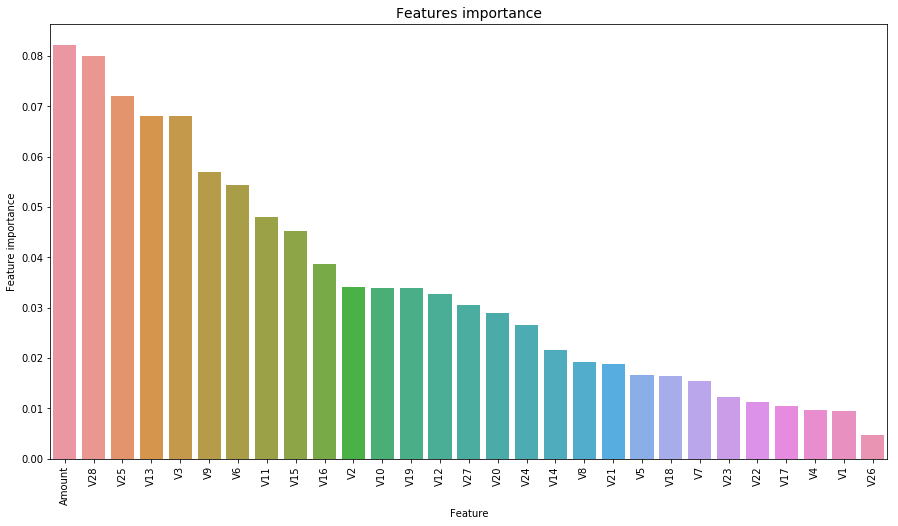

In [6]:
features = ['Amount', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 
            'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 
            'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 
            'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28']
featureImportance = gbt_model.featureImportances
print(featureImportance)
tmp = pd.DataFrame({'Feature': features, 'Feature importance': featureImportance})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (15,8))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()

## Step5. stratified cv with top features and best hyperparams

### Based on feature importance

### combo1: Amount ~ V24

In [3]:
df = sqlContext.read.csv("base_train.csv", header = True)
features = ['Amount', 'V28', 'V25', 'V13', 'V3', 'V9', 'V6', 'V11', 'V15', 'V16', 'V2', 'V10', 'V19', 'V12', 'V27', 'V20', 'V24']
gs_hyper, gs_precision, gs_recall, gs_fscore = tune(df, 5, True, 'None', 0, False, features, 'gbm', [4], [200], [0.1])
print("grid search precision:", gs_precision)
print("grid search recall:", gs_recall)
print("grid search f-score:", gs_fscore)
print("grid search hyper:", gs_hyper)

sqlContext.clearCache()

[4, 200, 0.1]
train after sampling: 145266
fraud ratio: 0.0016934451282474908
train after sampling: 145266
fraud ratio: 0.0016934451282474908
train after sampling: 145268
fraud ratio: 0.001700305641985847
train after sampling: 145266
fraud ratio: 0.0016934451282474908
train after sampling: 145270
fraud ratio: 0.0017002822330832244
[0.9061642612706443, 0.7339502908514014, 0.8110159406344248]
grid search precision: 0.9061642612706443
grid search recall: 0.7339502908514014
grid search f-score: 0.8110159406344248
grid search hyper: [4, 200, 0.1]


### combo2: Amount ~ V16

In [4]:
df = sqlContext.read.csv("base_train.csv", header = True)
features = ['Amount', 'V28', 'V25', 'V13', 'V3', 'V9', 'V6', 'V11', 'V15', 'V16']
gs_hyper, gs_precision, gs_recall, gs_fscore = tune(df, 5, True, 'None', 0, False, features, 'gbm', [4], [200], [0.1])
print("grid search precision:", gs_precision)
print("grid search recall:", gs_recall)
print("grid search f-score:", gs_fscore)
print("grid search hyper:", gs_hyper)

sqlContext.clearCache()

[4, 200, 0.1]
train after sampling: 145266
fraud ratio: 0.0016934451282474908
train after sampling: 145268
fraud ratio: 0.001700305641985847
train after sampling: 145266
fraud ratio: 0.0016934451282474908
train after sampling: 145266
fraud ratio: 0.0016934451282474908
train after sampling: 145270
fraud ratio: 0.0017002822330832244
[0.920931552772441, 0.7047065044949763, 0.7984390529393709]
grid search precision: 0.920931552772441
grid search recall: 0.7047065044949763
grid search f-score: 0.7984390529393709
grid search hyper: [4, 200, 0.1]


### combo3: Amount ~ V7

In [5]:
df = sqlContext.read.csv("base_train.csv", header = True)
features = ['Amount', 'V28', 'V25', 'V13', 'V3', 'V9', 'V6', 'V11', 'V15', 'V16', 'V2', 'V10', 'V19', 'V12', 'V27', 'V20', 'V24', 'V14', 'V8', 'V21', 'V5', 'V18', 'V7']
gs_hyper, gs_precision, gs_recall, gs_fscore = tune(df, 5, True, 'None', 0, False, features, 'gbm', [4], [200], [0.1])
print("grid search precision:", gs_precision)
print("grid search recall:", gs_recall)
print("grid search f-score:", gs_fscore)
print("grid search hyper:", gs_hyper)

sqlContext.clearCache()

[4, 200, 0.1]
train after sampling: 145266
fraud ratio: 0.0016934451282474908
train after sampling: 145266
fraud ratio: 0.0016934451282474908
train after sampling: 145268
fraud ratio: 0.001700305641985847
train after sampling: 145266
fraud ratio: 0.0016934451282474908
train after sampling: 145270
fraud ratio: 0.0017002822330832244
[0.9204787369493254, 0.7500264410364885, 0.8265564216404091]
grid search precision: 0.9204787369493254
grid search recall: 0.7500264410364885
grid search f-score: 0.8265564216404091
grid search hyper: [4, 200, 0.1]


### combo4: Amount ~ V1

In [6]:
df = sqlContext.read.csv("base_train.csv", header = True)
features = ['Amount', 'V28', 'V25', 'V13', 'V3', 'V9', 'V6', 'V11', 'V15', 'V16', 'V2', 'V10', 'V19', 'V12', 'V27', 'V20', 'V24', 'V14', 'V8', 'V21', 'V5', 'V18', 'V7','V23', 'V22', 'V17','V4', 'V1']
gs_hyper, gs_precision, gs_recall, gs_fscore = tune(df, 5, True, 'None', 0, False, features, 'gbm', [4], [200], [0.1])
print("grid search precision:", gs_precision)
print("grid search recall:", gs_recall)
print("grid search f-score:", gs_fscore)
print("grid search hyper:", gs_hyper)

sqlContext.clearCache()

[4, 200, 0.1]
train after sampling: 145266
fraud ratio: 0.0016934451282474908
train after sampling: 145266
fraud ratio: 0.0016934451282474908
train after sampling: 145268
fraud ratio: 0.001700305641985847
train after sampling: 145266
fraud ratio: 0.0016934451282474908
train after sampling: 145270
fraud ratio: 0.0017002822330832244
[0.9382606767230968, 0.7694870438921206, 0.8455340631598475]
grid search precision: 0.9382606767230968
grid search recall: 0.7694870438921206
grid search f-score: 0.8455340631598475
grid search hyper: [4, 200, 0.1]


### combo5: Amount ~ V4

In [8]:
df = sqlContext.read.csv("base_train.csv", header = True)
features = ['Amount', 'V28', 'V25', 'V13', 'V3', 'V9', 'V6', 'V11', 'V15', 'V16', 'V2', 'V10', 'V19', 'V12', 'V27', 'V20', 'V24', 'V14', 'V8', 'V21', 'V5', 'V18', 'V7','V23', 'V22', 'V17','V4']
gs_hyper, gs_precision, gs_recall, gs_fscore = tune(df, 5, True, 'None', 0, False, features, 'gbm', [4], [200], [0.1])
print("grid search precision:", gs_precision)
print("grid search recall:", gs_recall)
print("grid search f-score:", gs_fscore)
print("grid search hyper:", gs_hyper)

sqlContext.clearCache()

[4, 200, 0.1]
train after sampling: 145266
fraud ratio: 0.0016934451282474908
train after sampling: 145268
fraud ratio: 0.001700305641985847
train after sampling: 145266
fraud ratio: 0.0016934451282474908
train after sampling: 145266
fraud ratio: 0.0016934451282474908
train after sampling: 145270
fraud ratio: 0.0017002822330832244
[0.9315523987039842, 0.7726599682707562, 0.844699006735744]
grid search precision: 0.9315523987039842
grid search recall: 0.7726599682707562
grid search f-score: 0.844699006735744
grid search hyper: [4, 200, 0.1]


### Baed on t-test statistics

In [3]:
df = sqlContext.read.csv("base_train.csv", header = True)
features = ['V1','V2','V3','V4','V5','V6','V7','V8','V9','V10','V11','V12','V14','V15','V16','V17','V18','V19','V20','V21','V24','V27','V28','Amount']
gs_hyper, gs_precision, gs_recall, gs_fscore = tune(df, 5, True, 'None', 0, False, features, 'gbm', [4], [200], [0.1])
print("grid search precision:", gs_precision)
print("grid search recall:", gs_recall)
print("grid search f-score:", gs_fscore)
print("grid search hyper:", gs_hyper)

sqlContext.clearCache()

[4, 200, 0.1]
train after sampling: 145268
fraud ratio: 0.001700305641985847
train after sampling: 145266
fraud ratio: 0.0016934451282474908
train after sampling: 145266
fraud ratio: 0.0016934451282474908
train after sampling: 145266
fraud ratio: 0.0016934451282474908
train after sampling: 145270
fraud ratio: 0.0017002822330832244
[0.9208561685543784, 0.7663141195134848, 0.836507244105671]
grid search precision: 0.9208561685543784
grid search recall: 0.7663141195134848
grid search f-score: 0.836507244105671
grid search hyper: [4, 200, 0.1]


### It is found that excluding any feature results in a performance drop, so all features are reserved

## Step6: Compare stratified cv with no smapling and undersampling

In [4]:
df = sqlContext.read.csv("base_train.csv", header = True)
features = ['V1','V2','V3','V4','V5','V6','V7','V8','V9','V10','V11','V12','V13','V14','V15','V16','V17','V18','V19','V20','V21','V22','V23','V24','V25','V26','V27','V28','Amount']

for i in [0.005,0.01,0.05]:
    cv_hyper, cv_precision, cv_recall, cv_fscore = tune(df, 5, True, 'under', i, False, features, 'gbm', [4],[200],[0.1])
    print("grids search precision:", cv_precision)
    print("grids search recall:", cv_recall)
    print("grids search f-score:", cv_fscore)

sqlContext.clearCache()

[4, 200, 0.1]
train after sampling: 49399
fraud ratio: 0.0050001012166238186
train after sampling: 49200
fraud ratio: 0.005
train after sampling: 49200
fraud ratio: 0.005
train after sampling: 49200
fraud ratio: 0.005
train after sampling: 49399
fraud ratio: 0.0050001012166238186
[0.8613651637679555, 0.7922792173453199, 0.82537905440003]
grids search precision: 0.8613651637679555
grids search recall: 0.7922792173453199
grids search f-score: 0.82537905440003
[4, 200, 0.1]
train after sampling: 24700
fraud ratio: 0.01
train after sampling: 24600
fraud ratio: 0.01
train after sampling: 24600
fraud ratio: 0.01
train after sampling: 24600
fraud ratio: 0.01
train after sampling: 24700
fraud ratio: 0.01
[0.8032088353973746, 0.8019566367001586, 0.8025822476251104]
grids search precision: 0.8032088353973746
grids search recall: 0.8019566367001586
grids search f-score: 0.8025822476251104
[4, 200, 0.1]
train after sampling: 4939
fraud ratio: 0.05001012350678275
train after sampling: 4919
fraud ra

In [3]:
train_df= sqlContext.read.format('com.databricks.spark.csv').options(header='true', inferschema='true').load('base_train.csv')
test_df= sqlContext.read.format('com.databricks.spark.csv').options(header='true', inferschema='true').load('base_test.csv')

train_df = sample(train_df, "under", 0.005)
vectorAssembler = VectorAssembler(inputCols = ['V1','V2','V3','V4','V5','V6','V7','V8','V9','V10','V11','V12','V13','V14','V15','V16','V17','V18','V19','V20','V21','V22','V23','V24','V25','V26','V27','V28','Amount'], outputCol = 'features')
train_df_v = vectorAssembler.transform(train_df)
test_df_v = vectorAssembler.transform(test_df)
gbt = GBTClassifier(featuresCol = 'features',labelCol = 'Class', maxDepth = 4, maxIter = 200, stepSize = 0.1)

gbt_model = gbt.fit(train_df_v)
gbt_prediction = gbt_model.transform(test_df_v)
#bt_prediction.select('features','Class','prediction').show()

evaluator = BinaryClassificationEvaluator(labelCol="Class", metricName="areaUnderROC")
area = evaluator.evaluate(gbt_prediction)
pred = gbt_prediction
precision = pred.filter(pred.Class == pred.prediction).filter(pred.Class == 1.0).count() / pred.filter(pred.prediction == 1.0).count()
recall = pred.filter(pred.Class == pred.prediction).filter(pred.Class == 1.0).count() / pred.filter(pred.Class == 1.0).count()
f1 = 2 * precision * recall /(precision + recall)
print("Precision is ", precision)
print("Recall is ", recall)
print("F1 score is ", f1)
print("Test Area Under ROC: " + str(area))

train after sampling: 61599
fraud ratio: 0.005000081170148866
Precision is  0.8571428571428571
Recall is  0.8571428571428571
F1 score is  0.8571428571428571
Test Area Under ROC: 0.9836296360080017


### No performance improvement by undersamping, so just keep using entire dataset

## Step7: hold-out test

In [6]:
train_df= sqlContext.read.format('com.databricks.spark.csv').options(header='true', inferschema='true').load('base_train.csv')
oot_df= sqlContext.read.format('com.databricks.spark.csv').options(header='true', inferschema='true').load('oot.csv')
vectorAssembler = VectorAssembler(inputCols = ['V1','V2','V3','V4','V5','V6','V7','V8','V9','V10','V11','V12','V13','V14','V15','V16','V17','V18','V19','V20','V21','V22','V23','V24','V25','V26','V27','V28','Amount'], outputCol = 'features')
train_df_v = vectorAssembler.transform(train_df)
oot_df_v = vectorAssembler.transform(oot_df)
gbt = GBTClassifier(featuresCol = 'features',labelCol = 'Class', maxDepth = 4, maxIter = 200, stepSize = 0.1)

gbt_model = gbt.fit(train_df_v)
gbt_prediction = gbt_model.transform(oot_df_v)

evaluator = BinaryClassificationEvaluator(labelCol="Class", metricName="areaUnderROC")
area = evaluator.evaluate(gbt_prediction)
pred = gbt_prediction
precision = pred.filter(pred.Class == pred.prediction).filter(pred.Class == 1.0).count() / pred.filter(pred.prediction == 1.0).count()
recall = pred.filter(pred.Class == pred.prediction).filter(pred.Class == 1.0).count() / pred.filter(pred.Class == 1.0).count()
f1 = 2 * precision * recall /(precision + recall)
print("Precision is ", precision)
print("Recall is ", recall)
print("F1 score is ", f1)
print("Test Area Under ROC: " + str(area))

Precision is  0.9272727272727272
Recall is  0.6891891891891891
F1 score is  0.7906976744186047
Test Area Under ROC: 0.9881642300120628
